In [ ]:
!sudo apt-get upgrade

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Calculating upgrade... Done
The following packages have been kept back:
  libcudnn8 libcudnn8-dev libnccl-dev libnccl2 linux-headers-generic
The following packages will be upgraded:
  binutils binutils-common binutils-x86-64-linux-gnu cuda-compat-11-0 gnupg2
  libarchive13 libaudit-common libaudit1 libbinutils libc-bin libcublas-dev
  libcublas10 libcudnn7 libcudnn7-dev libhogweed4 libldap-2.4-2 libldap-common
  liblz4-1 libnettle6 libp11-kit0 libpam-modules libpam-modules-bin
  libpam-runtime libpam0g libperl5.26 libsasl2-2 libsasl2-modules-db
  libseccomp2 libzstd1 linux-libc-dev openssl perl perl-base perl-modules-5.26
  python-apt-common python3-apt r-cran-devtools r-cran-matrix r-cran-mgcv
  r-cran-remotes r-cran-rversions tar ubuntu-keyring
43 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
Need to get 469 MB of archives.
After this operation, 69.9 MB of additional disk sp

In [ ]:
!pip install keras-facenet

     |████████████████████████████████| 2.3MB 28.1MB/s 
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-cp37-none-any.whl size=10386 sha256=28cfbab059ab2456100a96be86b0a410db5c2dcca35c0cfaa9a6dfaf0f5dbe34
  Stored in directory: /root/.cache/pip/wheels/f6/53/9a/36c4b52fd22faf4f710d5047d874655b85a1b2cf77accfb9bd
Successfully built keras-facenet


In [ ]:
from keras_facenet import FaceNet
from tqdm import tqdm
import os

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

import numpy as np

embedder = FaceNet()

In [ ]:
X, y = [], []
path_to_data = '/content/data/'

failure = []

for dir_name in os.listdir(path_to_data):
  for file_name in tqdm(os.listdir(f'{path_to_data}/{dir_name}')):

    path_to_image = f'{path_to_data}{dir_name}/{file_name}'

    try:
      detections = embedder.extract(path_to_image, threshold=0.95)
      emb = detections[0]['embedding'] 
      X.append(emb)
      y.append(dir_name)
    except:
      failure.append(path_to_image)

  0%|          | 0/504 [00:00<?, ?it/s]

100%|██████████| 427/427 [05:01<00:00,  1.42it/s]


In [ ]:
len(failure)

5

In [ ]:
failure

['/content/data/other/150.jpg',
 '/content/data/other/120.jpg',
 '/content/data/other/199.jpg',
 '/content/data/putin/putin92.jpeg',
 '/content/data/putin/putin149.jpeg']

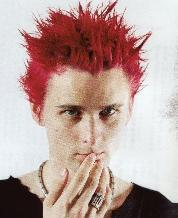

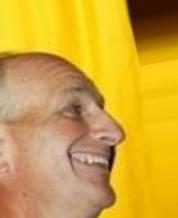

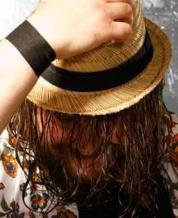

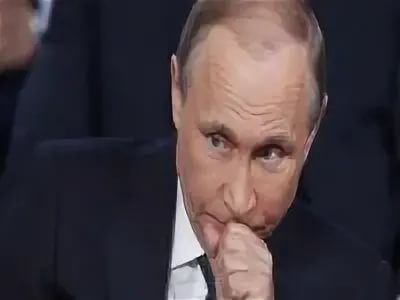

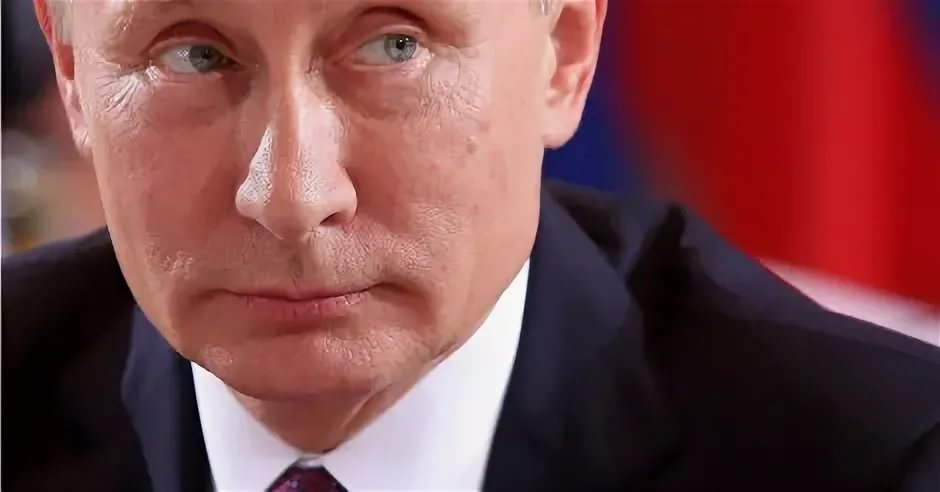

In [ ]:
from IPython.display import Image, display

for i in failure:
  display(Image(i))

In [ ]:
len(X), len(y)

(926, 926)

In [ ]:
y[0], y[900]

('other', 'putin')

Кэшировал данные, чтобы не загружать по новой.

In [ ]:
X = (np.load('/content/drive/MyDrive/data.npy')).tolist() 
y = (np.load('/content/drive/MyDrive/data_y.npy')).tolist()

In [ ]:
in_encoder = Normalizer(norm='l2')
X = in_encoder.transform(X)

In [ ]:
out_encoder = LabelEncoder()
out_encoder.fit(y)
y = out_encoder.transform(y)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=179 
)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(648, 278, 648, 278)

In [ ]:
model = SVC(kernel='poly', random_state=179)
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=179, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
# predict
yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

# score
score_train = accuracy_score(y_train, yhat_train)
score_test = accuracy_score(y_test, yhat_test)

# precision
prec_train = precision_score(y_train, yhat_train)
prec_test = precision_score(y_test, yhat_test)

# recall
rec_train = recall_score(y_train, yhat_train)
rec_test = recall_score(y_test, yhat_test)

# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))
print('Precision: train=%.3f, test=%.3f' % (prec_train*100, prec_test*100))
print('Recall: train=%.3f, test=%.3f' % (rec_train*100, rec_test*100))

Accuracy: train=100.000, test=98.921
Precision: train=100.000, test=100.000
Recall: train=100.000, test=97.414


Создадим функцию, которой можно будет подавать на вход путь к изображени.Функция будет возвращать предсказанные класс. 

In [ ]:
def get_prediction(path_to_image):
  try:
    detections = embedder.extract(path_to_image, threshold=0.95)
    emb = detections[0]['embedding']

    if len(detections) == 1:
      return model.predict(Normalizer(norm='l2').transform([emb]))
    else:
      return -1  # 'На фото больше одного лица. Кто в итоге хочет пройти?'
  except IndexError:
    return -2  # 'На изображении плохо видно лицо\nСделай, пожалуйста, новую фотографию :)'

    if len(detections) == 1:
      return model.predict(Normalizer(norm='l2').transform([emb]))
    else:
      return 'На фото больше одного лица. Кто в итоге хочет пройти?'
  except IndexError:
    print('На изображении плохо видно лицо\nСделай, пожалуйста, новую фотографию :)')


[0]


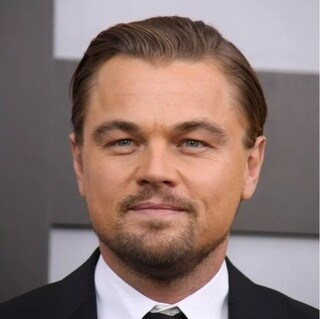

In [ ]:
print(get_predicition('di.jpg'))
Image('di.jpg')

# Кэширование



In [ ]:
import numpy as np

In [ ]:
X_np = np.array(X)

In [ ]:
y_np = np.array(y)

In [ ]:
np.save('data.npy', X_np) # save
new_num_arr = np.load('data.npy') # load

In [ ]:
np.save('data_y.npy', y_np) # save

In [ ]:
X_np == new_num_arr

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
# a = np.array([1, 2, 3, 4])
# np.savetxt('test1.txt', a, fmt='%d')
# b = np.loadtxt('test1.txt', dtype=int)
# a == b
# array([ True,  True,  True,  True], dtype=bool)